# Loading the parquet file

- i am using 10 million rows currently

In [ ]:
import pandas as pd, numpy as np
from glob import glob

in_path = glob('/Users/alialshaikh/Downloads/itineraries_snappy.parquet')[0]
df = pd.read_parquet(in_path,engine='pyarrow',use_threads=True)

import pyarrow.parquet as pq
import pandas as pd

# Path to the file
in_path = '/Users/alialshaikh/Downloads/itineraries_snappy.parquet'

# Open the Parquet file
parquet_file = pq.ParquetFile(in_path)

# Read the first 100,000 rows
table = parquet_file.read_row_groups(range(parquet_file.num_row_groups))  # Read all row groups

table.num_rows # number of rows we have

table_slice = table.slice(0, 10000000)  # Slice the first 100,000 rows

# Convert to pandas DataFrame
df = table_slice.to_pandas()


from here we can dynamically change the dataframe size

## Imports

In [70]:
import pandas as pd ,matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
pd.set_option("display.max_columns", 999)

In [3]:
# loaded at the end
df = pd.read_csv('final_2million_flight_ticket.csv')

In [4]:
# Step 1: Clean and split airline names
df['segmentsAirlineName'] = df['segmentsAirlineName'].str.replace(r'\s*\|\|\s*', '||', regex=True)

In [5]:
data_dictionary = dict( legId = "An identifier for the flight.",
      searchDate= "The date (YYYY-MM-DD) on which this entry was taken from Expedia.",
      flightDate= "The date (YYYY-MM-DD) of the flight.",
      startingAirport= "Three-character IATA airport code for the initial location.",
      destinationAirport= "Three-character IATA airport code for the arrival location.",
      fareBasisCode= "The fare basis code.",
      travelDuration= "The travel duration in hours and minutes.",
      elapsedDays= "The number of elapsed days (usually 0).",
      isBasicEconomy= "Boolean for whether the ticket is for basic economy.",
      isRefundable= "Boolean for whether the ticket is refundable.",
      isNonStop=" Boolean for whether the flight is non-stop.",
      baseFare= "The price of the ticket (in USD).",
      totalFare= "The price of the ticket (in USD) including taxes and other fees.",
      seatsRemaining=" Integer for the number of seats remaining.",
      totalTravelDistance= "The total travel distance in miles. This data is sometimes missing.",
      segmentsDepartureTimeEpochSeconds= "String containing the departure time (Unix time) for each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsDepartureTimeRaw= "String containing the departure time (ISO 8601 format: YYYY-MM-DDThh:mm:ss.000±[hh]:00) for each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsArrivalTimeEpochSeconds= "String containing the arrival time (Unix time) for each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsArrivalTimeRaw= "String containing the arrival time (ISO 8601 format: YYYY-MM-DDThh:mm:ss.000±[hh]:00) for each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsArrivalAirportCode= "String containing the IATA airport code for the arrival location for each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsDepartureAirportCode= "String containing the IATA airport code for the departure location for each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsAirlineName= "String containing the name of the airline that services each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsAirlineCode= "String containing the two-letter airline code that services each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsEquipmentDescription= "String containing the type of airplane used for each leg of the trip (e.g. \"Airbus A321\" or \"Boeing 737-800\"). The entries for each of the legs are separated by '||'.",
      segmentsDurationInSeconds= "String containing the duration of the flight (in seconds) for each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsDistance= "String containing the distance traveled (in miles) for each leg of the trip. The entries for each of the legs are separated by '||'.",
      segmentsCabinCode= "String containing the cabin for each leg of the trip (e.g. \"coach\"). The entries for each of the legs are separated by '||'.")

#### drop the null values

In [6]:
df.isna().sum()[:20]

legId                                0
searchDate                           0
flightDate                           0
startingAirport                      0
destinationAirport                   0
fareBasisCode                        0
travelDuration                       0
elapsedDays                          0
isBasicEconomy                       0
isRefundable                         0
isNonStop                            0
baseFare                             0
totalFare                            0
seatsRemaining                       0
segmentsDepartureTimeEpochSeconds    0
segmentsDepartureTimeRaw             0
segmentsArrivalTimeEpochSeconds      0
segmentsArrivalTimeRaw               0
segmentsArrivalAirportCode           0
segmentsDepartureAirportCode         0
dtype: int64

In [7]:
df.isna().sum()[20:]


segmentsAirlineName             0
segmentsAirlineCode             0
segmentsEquipmentDescription    0
segmentsDurationInSeconds       0
segmentsDistance                0
segmentsCabinCode               0
totalTravelDistance             0
departure                       0
arrival                         0
route                           0
full_route                      0
dtype: int64

In [8]:
df.dropna(subset=['segmentsEquipmentDescription', 'segmentsDistance'], inplace=True)

In [ ]:
def calculate_total_traveled_distance(segment_distance_list):
  vals = segment_distance_list.split('||')
  # i.isdigit() is a str method in python
  valid_values = [ i for i in vals if i and i.isdigit()]
  return sum(map(int,valid_values))

In [ ]:
df['total_distance'] = df['segmentsDistance'].apply(calculate_total_traveled_distance) #.apply() runs in C-optimized pandas code. inshort python is slow, C is very fast

In [ ]:
df = df.drop(['totalTravelDistance'], axis=1)

In [ ]:
# df.rename(columns={'old_column_name': 'new_column_name'})

df = df.rename(columns={'total_distance': 'totalTravelDistance'})

## POSSIBLE ANSWER

In [9]:
df.loc[:,['baseFare','totalFare']][(df['baseFare'] >= 5) & (df['baseFare'] <= 10)].shape[0]

2276

There is 2276 tickets which had a baseFare that is less than 10 dollars and greater than 5 dollars

but what about the total Fare ? 

In [10]:
min_totalFare = df.loc[:,['baseFare','totalFare','isRefundable','segmentsArrivalAirportCode','segmentsDepartureAirportCode']][(df['totalFare'] <= 23.97 )]

min_totalFare.shape , min_totalFare.nunique()

((28, 5),
 baseFare                        1
 totalFare                       1
 isRefundable                    1
 segmentsArrivalAirportCode      2
 segmentsDepartureAirportCode    2
 dtype: int64)

from this line of code we can understand that the minmum price of the `totalFare` column, occurs 28 times in the dataset, and from the dataset we can see that the departure airport and the arrival airport contains only 2 values which is : `SFO`,`ONT`; which means the traveler is going either from San Francisco International Airport (SFO) to Ontario International Airport (ONT) or vice versa (ONT to SFO).

In [23]:
float(df['baseFare'].min()), float(df['baseFare'].max())

(5.1, 4407.44)

In [24]:
float(df['totalFare'].min()), float(df['totalFare'].max())


(23.97, 4752.6)

In [25]:
df[df['totalFare'] == 4752.6]

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,totalTravelDistance,departure,arrival,route,full_route
1087835,afbb806b2657ae577266a926030b71f3,2022-04-19,2022-04-23,LAX,JFK,FA3AA,PT5H30M,0,False,False,True,4407.44,4752.6,2,1650736800,2022-04-23T11:00:00.000-07:00,1650756600,2022-04-23T19:30:00.000-04:00,JFK,LAX,American Airlines,AA,AIRBUS INDUSTRIE A321 SHARKLETS,19800,2458,first,2458,LAX,JFK,LAX->JFK,LAX -> JFK
1094680,b7d27647a9254b4ae4eda74e1585f88f,2022-04-19,2022-04-24,LAX,JFK,FA3AA,PT5H28M,1,False,False,True,4407.44,4752.6,4,1650862800,2022-04-24T22:00:00.000-07:00,1650882480,2022-04-25T06:28:00.000-04:00,JFK,LAX,American Airlines,AA,AIRBUS INDUSTRIE A321 SHARKLETS,19680,2458,first,2458,LAX,JFK,LAX->JFK,LAX -> JFK
1094681,958f5d2e8d9d081ced07871dfdd1fd9e,2022-04-19,2022-04-24,LAX,JFK,FA3AA,PT5H32M,0,False,False,True,4407.44,4752.6,1,1650805200,2022-04-24T06:00:00.000-07:00,1650825120,2022-04-24T14:32:00.000-04:00,JFK,LAX,American Airlines,AA,AIRBUS INDUSTRIE A321 SHARKLETS,19920,2458,first,2458,LAX,JFK,LAX->JFK,LAX -> JFK
1097185,d4ec7414ce7ee3a871ef513d64ad6032,2022-04-19,2022-04-24,SFO,JFK,FA3AA,PT5H51M,0,False,False,True,4407.44,4752.6,1,1650823440,2022-04-24T11:04:00.000-07:00,1650844500,2022-04-24T19:55:00.000-04:00,JFK,SFO,American Airlines,AA,AIRBUS INDUSTRIE A321 SHARKLETS,21060,2566,first,2566,SFO,JFK,SFO->JFK,SFO -> JFK
1905995,404c074e4c744aadb321712d88ed60cf,2022-04-21,2022-04-23,LAX,JFK,FA3AA,PT5H32M,0,False,False,True,4407.44,4752.6,1,1650729600,2022-04-23T09:00:00.000-07:00,1650749520,2022-04-23T17:32:00.000-04:00,JFK,LAX,American Airlines,AA,AIRBUS INDUSTRIE A321 SHARKLETS,19920,2458,first,2458,LAX,JFK,LAX->JFK,LAX -> JFK
1912694,b7d27647a9254b4ae4eda74e1585f88f,2022-04-21,2022-04-24,LAX,JFK,FA3AA,PT5H28M,1,False,False,True,4407.44,4752.6,4,1650862800,2022-04-24T22:00:00.000-07:00,1650882480,2022-04-25T06:28:00.000-04:00,JFK,LAX,American Airlines,AA,AIRBUS INDUSTRIE A321 SHARKLETS,19680,2458,first,2458,LAX,JFK,LAX->JFK,LAX -> JFK
1914918,d4ec7414ce7ee3a871ef513d64ad6032,2022-04-21,2022-04-24,SFO,JFK,FA3AA,PT5H51M,0,False,False,True,4407.44,4752.6,2,1650823440,2022-04-24T11:04:00.000-07:00,1650844500,2022-04-24T19:55:00.000-04:00,JFK,SFO,American Airlines,AA,AIRBUS INDUSTRIE A321 SHARKLETS,21060,2566,first,2566,SFO,JFK,SFO->JFK,SFO -> JFK


we can see here that: 
-  the minmum fare price without taxes is `$ 5.1`, taxes applied = `$ 23.97`
-  the maximum fare price without taxes is `$ 4407.1`, taxes applied = `$ 4752.6`


## POSSIBLE ANSWER

#### Count the occurences of airports -- 1st question

- what is the most used airport for arrivals ? 
- what is the most used airport for departures ? 
- what is the most used airport for both cases ? 

In [11]:
arrival_airports = df['segmentsArrivalAirportCode'].str.split(r'\|\|').explode()
arrival_airport_count = arrival_airports.value_counts()

In [12]:
departure_airports = df['segmentsDepartureAirportCode'].str.split(r'\|\|').explode()
departure_airport_count = departure_airports.value_counts()

In [13]:
airport_count = pd.concat([arrival_airport_count,departure_airport_count], axis=1)
airport_count.columns = ['arrival_airport_count','departure_airport_count']

In [14]:
airport_count['total_arrival_departure'] = airport_count['arrival_airport_count'] +  airport_count['departure_airport_count']

In [23]:
airport_count.head(5)

,arrival_airport_count,departure_airport_count,total_arrival_departure
ORD,289223,287757,576980
ATL,269600,262723,532323
CLT,232016,227715,459731
LAX,221879,225488,447367
EWR,194117,193932,388049


<Axes: >

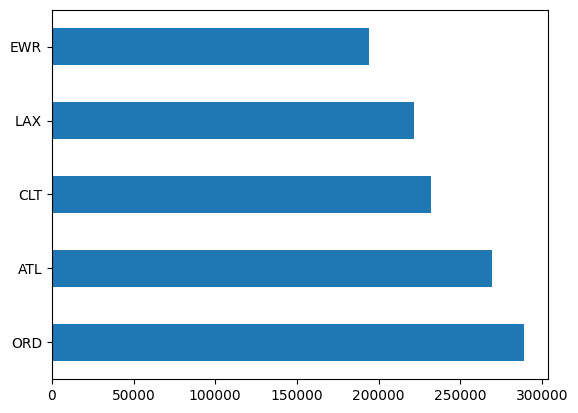

In [29]:
airport_count['arrival_airport_count'].head().plot(kind='barh')


<Axes: >

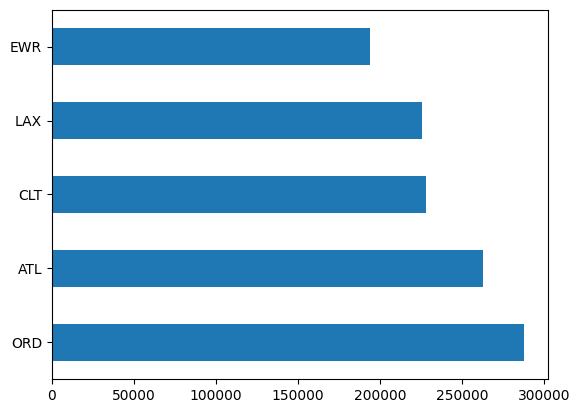

In [31]:
airport_count['departure_airport_count'].head().plot(kind='barh')

## POSSIBLE ANSWER

#### Count the number of multi-leg flights
- `how many multi-leg flights are there in the dataset ? `
- what is the most used connection ? ` HERE 😍`
- how many travelers use a multi-leg flight ?  `use a histogram`
- are multi-leg flights cheaper  ?  `use a histogram`
- what kind of connections for the full flights are used ?  `later ... `

#### Question: What is the count of the multi-leg flights ? 

In [32]:
# count the number of multi-leg flights
filter = df['segmentsArrivalAirportCode'].str.contains(r'\|\|', na=False) # what is na= ? 

In [33]:
number_multi_leg_flights = len(df[filter][['segmentsArrivalAirportCode','segmentsDepartureAirportCode']]) # output = 1,430,064 rows

In [37]:
print(f' The number of multi-leg flights currently {number_multi_leg_flights}')

 The number of multi-leg flights currently 1430064


### Identify Common Connections in Multi-Leg Flights

- by the common connection i am searching here for something like: `LGA --> ORD`
- So by a common connection we are refering for something like departure:
1. Departure Column -> `ATL||CMH`	
2. Arrival Column -> `CMH||DTW`

what i am trying to see is from the Departure Column `ATL` and from the Arrival Column `CMH` to see which connections from 1 place to another place is being used the most.

In [38]:
df[['segmentsDepartureAirportCode','segmentsArrivalAirportCode']]

,segmentsDepartureAirportCode,segmentsArrivalAirportCode
0,ATL,BOS
1,ATL,BOS
2,ATL,BOS
3,ATL,BOS
4,ATL,BOS
...,...,...
1952072,ATL||CMH,CMH||DTW
1952073,ATL||CHA,CHA||DTW
1952074,ATL||ORF,ORF||DTW
1952075,ATL,EWR


In [64]:
# Extract the first departure and arrival airport codes
# taking the first column from the list as explained above
df['departure'] = df['segmentsDepartureAirportCode'].str.split(r'\|\|', expand=True)[0] 
df['arrival'] = df['segmentsArrivalAirportCode'].str.split(r'\|\|', expand=True)[0] # the 1st item in the 'list' <- easier to think of it as a list



In [65]:
# Create a "route" column
df['route'] = df['departure'] + "->" + df['arrival']

In [39]:
# 'value_counts()' returns a dataframe with the column name and the count of each distinct element in the column

df['route'].value_counts().reset_index()

,route,count
0,LGA->ORD,31230
1,OAK->LAX,26207
2,BOS->EWR,24519
3,MIA->ATL,24067
4,PHL->ORD,23474
...,...,...
1041,CLT->GRR,1
1042,CLT->ABE,1
1043,SFO->BNA,1
1044,EWR->STL,1


Text(0, 0.5, 'Connection')

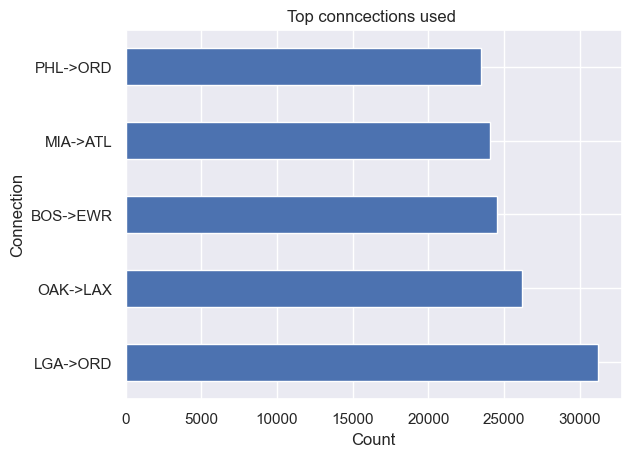

In [49]:
sns.set_theme()
plt.title("Top conncections used ")
df['route'].value_counts().head(5).plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Connection')


In [72]:
df[['segmentsDepartureAirportCode','segmentsArrivalAirportCode']].iloc[1952072,:]

segmentsDepartureAirportCode    ATL||CMH
segmentsArrivalAirportCode      CMH||DTW
Name: 1952072, dtype: object

## THE MOST COMMON CONNECTION IS LGA->ORD WHICH IS ?

`LaGuardia Airport (LGA) in New York City to O’Hare International Airport (ORD) in Chicago.`

In [75]:
# Count occurrences of each route
route_counts = df['route'].value_counts().reset_index() # a very cool trick which is the reset_index()
route_counts.columns = ['Route', 'Count']

these are the most popular route as start to departure, `but it may be just a transit`

i would like to know the most popular route as start to finish ☕️😆

### MAKE THE FOLLOWING CODE FASTER

### Question: what is the most used full connection as in `departure to destination`? 

sub-questions: 
- how many travelers use a multi-leg flight ? 
- are multi-leg flights cheaper ? 
- what kind of connections for the full flights are used ? 

In [81]:
# Split departure and arrival segments
departure_segments = df['segmentsDepartureAirportCode'].str.split(r'\|\|', expand=True)
arrival_segments = df['segmentsArrivalAirportCode'].str.split(r'\|\|', expand=True)

In [82]:
# Fill NaN with empty strings
departure_segments = departure_segments.fillna('')
arrival_segments = arrival_segments.fillna('')

departure_segments


,0,1,2,3
0,ATL,,,
1,ATL,,,
2,ATL,,,
3,ATL,,,
4,ATL,,,
...,...,...,...,...
1952072,ATL,CMH,,
1952073,ATL,CHA,,
1952074,ATL,ORF,,
1952075,ATL,,,


In [ ]:
dp = departure_segments.apply(lambda row: ' -> '.join(row[row != '']), axis=1)

In [ ]:
ap = arrival_segments.apply(lambda row: ' -> '.join(row[row != '']), axis=1)

In [ ]:
# Merge departure and arrival segments, ensuring empty segments are removed
df['full_route'] =  dp + " -> " + ap

In [ ]:
# Clean up any trailing " -> " that appears if arrival part is empty
df['full_route'] = df['full_route'].str.rstrip(' -> ')


#### Question: where people in the US usually fly to ? `as in starting point to END Destination`

In [50]:
start_location =  df['segmentsDepartureAirportCode'].str.split(r'\|\|', expand=True)[0] 

In [51]:
def get_final_destination(x):
  final = ''
  for i in x: 
    if i != None: 
      final = i
      
  return final

In [52]:
end_location = df['segmentsArrivalAirportCode'].str.split(r'\|\|').apply(get_final_destination)

In [53]:
df['start_END_Destination'] = start_location + '->' + end_location

In [55]:
df[['segmentsDepartureAirportCode','segmentsArrivalAirportCode','full_route','start_END_Destination']]

,segmentsDepartureAirportCode,segmentsArrivalAirportCode,full_route,start_END_Destination
0,ATL,BOS,ATL -> BOS,ATL->BOS
1,ATL,BOS,ATL -> BOS,ATL->BOS
2,ATL,BOS,ATL -> BOS,ATL->BOS
3,ATL,BOS,ATL -> BOS,ATL->BOS
4,ATL,BOS,ATL -> BOS,ATL->BOS
...,...,...,...,...
1952072,ATL||CMH,CMH||DTW,ATL -> CMH -> CMH -> DTW,ATL->DTW
1952073,ATL||CHA,CHA||DTW,ATL -> CHA -> CHA -> DTW,ATL->DTW
1952074,ATL||ORF,ORF||DTW,ATL -> ORF -> ORF -> DTW,ATL->DTW
1952075,ATL,EWR,ATL -> EWR,ATL->EWR


Text(0, 0.5, 'Start to End Destinations ')

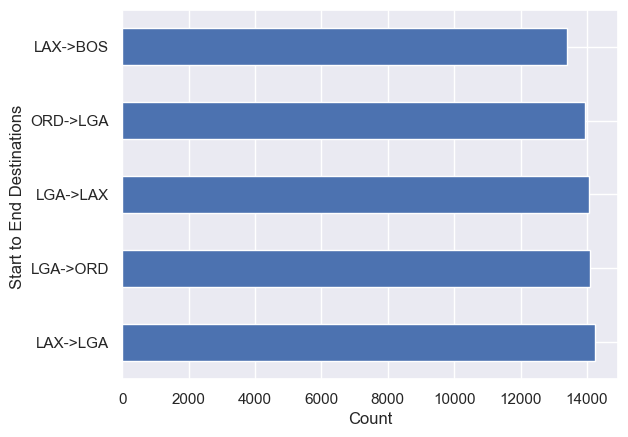

In [60]:
route_counts = df['start_END_Destination'].value_counts()
route_counts.head(5).plot(kind='barh')
plt.xlabel("Count")
plt.ylabel("Start to End Destinations ")

Now we have the count of each full route for all the airplane tickets, where we can see the `start` and the `end` destination. 

## Question: does the amount of departures affect the final totalFare of the ticket ? 

### Sub-Question: 
- what does most people prefer ? `direct tickets ?` | `Single Stop tickets` | `More than 1 stop tickets`
- which one contains the cheapest fares ? 
- what is better ? travelling using the direct ticket or 2 departures or 3+ departures ? 

      - tell them about the min price of each type, why the minimum of the 2 departures is higher than the minimum of a single departure ? while the max tells another story ? 


In [56]:
df['full_route'].tail()

1952072    ATL -> CMH -> CMH -> DTW
1952073    ATL -> CHA -> CHA -> DTW
1952074    ATL -> ORF -> ORF -> DTW
1952075                  ATL -> EWR
1952076    ATL -> CLT -> CLT -> EWR
Name: full_route, dtype: object

## `Work related to number of departures` AND `HOW IT AFFECTS THE TOTAL FARE`

In [61]:
# i want to catch the flights where the departure segment contains something like 
# Filter rows where column 0 contains at least two "->" separators
# three_or_more_departures_df = df[df['full_route'].str.contains(r'[^ ]+ -> [^ ]+ -> ', regex=True)]
three_or_more_departures_df = df[df['segmentsDepartureAirportCode'].str.contains(r"^[A-Z]{3}\|\|[A-Z]{3}\|\|", regex=True)]

print(f' Tickets with at least 3 departures          {three_or_more_departures_df.shape[0]}')
print(f' The Size of the original dataframe          {df.shape[0]}')



 Tickets with at least 3 departures          144024
 The Size of the original dataframe          1952077


In [62]:
df.startingAirport.unique()

array(['ATL', 'BOS', 'CLT', 'DEN', 'DFW', 'DTW', 'EWR', 'IAD', 'JFK',
       'LAX', 'LGA', 'MIA', 'OAK', 'ORD', 'PHL', 'SFO'], dtype=object)

In [63]:
arrival_airports = 'segmentsArrivalAirportCode'	
departure_airports = 'segmentsDepartureAirportCode'

# i want tickets which exactly have 2 departures
two_departure_df = df[
    df[departure_airports].str.contains(r"^[A-Z]{3}\|\|[A-Z]{3}$", regex=True)
]

In [64]:
# i want tickets which exactly have 1 departure
nonStop_tickets = df[
    df[departure_airports].str.contains(r"^[A-Z]{3}$", regex=True)
]

In [65]:
two_departure_df.shape[0],three_or_more_departures_df.shape[0],nonStop_tickets.shape[0],df.shape[0]

(1286040, 144024, 522013, 1952077)

In [66]:

nonStop_tickets.shape[0]+ two_departure_df.shape[0] + three_or_more_departures_df.shape[0] == df.shape[0] # correct values, no df contains data from others. so all are pure correct 😍

True

# `Now to the Question everyone is waiting for`, does having more Departures affects the total fare ? and  most people prefer flying through what ? 

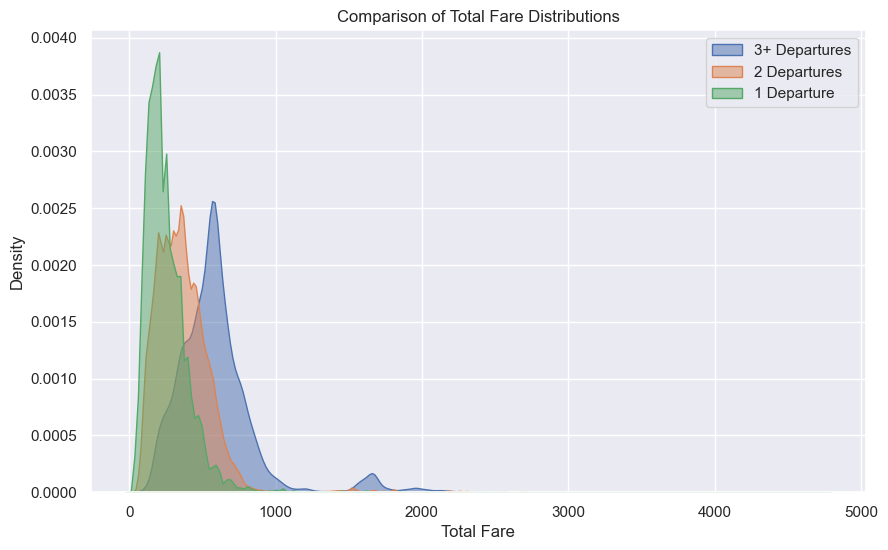

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(three_or_more_departures_df.totalFare, label='3+ Departures', fill=True, alpha=0.5)
sns.kdeplot(two_departure_df.totalFare, label='2 Departures', fill=True, alpha=0.5)
sns.kdeplot(nonStop_tickets.totalFare, label='1 Departure', fill=True, alpha=0.5)

plt.xlabel('Total Fare')
plt.ylabel('Density')
plt.title('Comparison of Total Fare Distributions')
plt.legend()
plt.show()

 very cool graph, it is working nicely



 - the green part shows that the 1 departure tickets are cheaper and `most people prefer them`
 - the orange part shows that the 2 departure tickets are still preferred, they are a little bit pricier than the 1 departure, but it still `people prefer them`



 this graph is basically not showing the raw data exactly, they are being normalized (using windows - these windows can be using different methods such as {median, min, max, mean}) or just a simple method that is like dividing the `count/total count`.

histograms are more accurate because we can play with the bins which help us get more insights much easier and faster

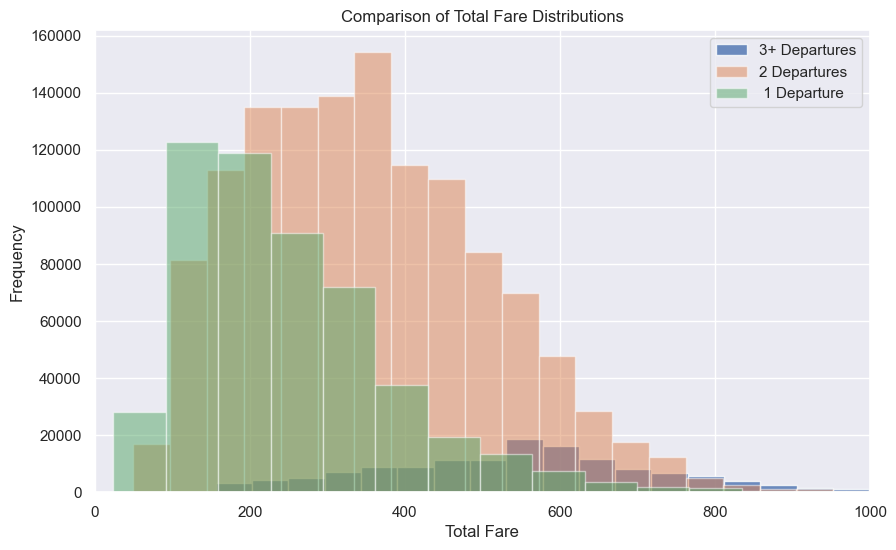

In [68]:
# Plot histograms together
plt.figure(figsize=(10, 6))
three_or_more_departures_df.totalFare.hist(alpha=0.8, label='3+ Departures', bins=70)
two_departure_df.totalFare.hist(alpha=0.5, label='2 Departures', bins=70)
nonStop_tickets.totalFare.hist(alpha=0.5, label=' 1 Departure', bins=70)


# Add labels and title
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.title('Comparison of Total Fare Distributions')
plt.xlim((0,1000))
plt.legend()

# Show the plot
plt.show()

 very cool graph, it is working nicely



 - the green part shows that the 1 departure tickets are cheaper and `most people prefer them`
 - the orange part shows that the 2 departure tickets are still preferred, they are a little bit pricier than the 1 departure, but it still `people prefer them`


## possible answer 

#### Now We will answer the question everyone is waiting for, which is: 
- ` does having more departures or layovers makes the ticket cheaper ? `

how shall i tackle this challange ? 
- i have tickets where we have at least 3 departures 
- let's get tickets with 2 departures exactly
- let's get tickets with 1 departures exactly
- let's compare them, but how can we compare these 2 filtered dataframes by the total fare ?
- shall we take the sum of the total fare? shall we take the average of the fare ? shall we take the std ? shall we take the variance ? 
- we'll see

In [ ]:
float(df.totalFare.min()), float(df.totalFare.max())

(23.97, 4752.6)

In [ ]:
float(nonStop_tickets.totalFare.min()),float(nonStop_tickets.totalFare.max())

(23.97, 4752.6)

In [ ]:
float(two_departure_df.totalFare.min()),float(two_departure_df.totalFare.max())

(49.69, 3376.6)

In [ ]:
float(three_or_more_departures_df.totalFare.min()),float(three_or_more_departures_df.totalFare.max())

(62.38, 3341.09)

what can we learn from the max and the min here ? 
- the max values suggest our first intiuition which is as the number of stops increase, the price gets lower and we can sense this by looking at the maximum value of each filter we used
the min tells us a different story:

<li> for MIN prices we can see the following:
  <ul> 
    <li> one-way-tickets min : 23.97</li>
    <li> two-way-tickets min : 49.69</li>
    <li> at least three-way-tickets min : 62.38 </li>
  </ul>     
</li>

`CONCLUSION: for short travels in terms of distance, travel one way`

<li> for MAX prices we can see the following:
  <ul> 
    <li> one-way-tickets MAX : 4752.6</li>
    <li> two-way-tickets MAX : 3376.6</li>
    <li> at least three-way-tickets MAX : 3341.09 </li>
  </ul>
</li>

`CONCLUSION: for long travels in terms of distance, travel three way - considering other factors equal -- ceteris paribus`




## possible Answer

things i want to see: 
- the airplane tickets are they round trip ? 
- all of these are one tickets right ? 
- so one way tickets but some have some stops in between which makes the ticket cheaper or expensive in some cases.

#### `Most used airlines ? `

In [ ]:
df['segmentsAirlineName'].str.split(r"\|\|").explode().value_counts()

segmentsAirlineName
American Airlines           968718
Delta                       914335
United                      900036
Alaska Airlines             230803
JetBlue Airways             222090
Spirit Airlines             214847
Frontier Airlines            50007
Cape Air                     15963
Southern Airways Express      5592
Sun Country Airlines          4160
Key Lime Air                  3268
Boutique Air                  2730
Contour Airlines               550
Name: count, dtype: int64

Text(0.5, 0, 'Count')

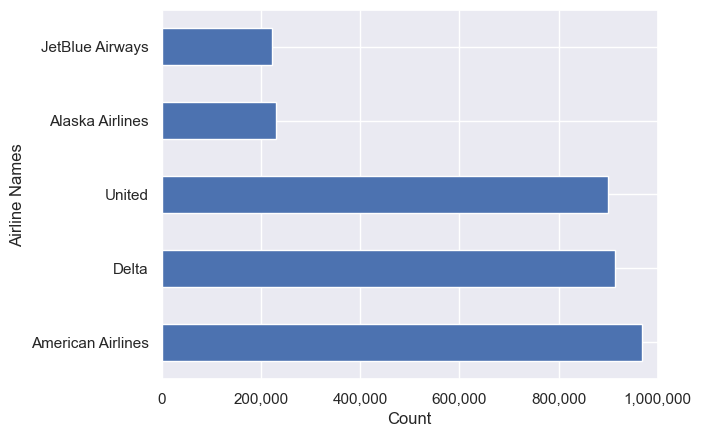

In [75]:
ax = df['segmentsAirlineName'].str.split(r"\|\|").explode().value_counts().head().plot(kind='barh')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Format x-axis numbers with commas
plt.xlim(0, 1_000_000)  # Set x-axis range manually
plt.ylabel("Airline Names")
plt.xlabel("Count")

We can now say that top 3 airlines are: 
- American Airlines 
- Delta
- United


then we can run more conclusions over this. such as most travelers travel through these airlines for different reasons; we can here make an online search to see why people travel through these airlines ? 

In [76]:
# IGNORE THIS CELL

# training on the lambda function
# counting the number of values in each array in the new series obj 'a'
# we can see the max value and the min value 
# from this information we can make a function which will make our lives easier to count the number of airlines that is used for departure and arrival
# a = df['segmentsAirlineName'].str.split(r"\|\|")
# h = a.apply(lambda x : len(x))
# h.max()

#### understanding the 'segmentsAirlineName'

## possible answer

Text(0.5, 1.0, ' Cheapiest Airline connections')

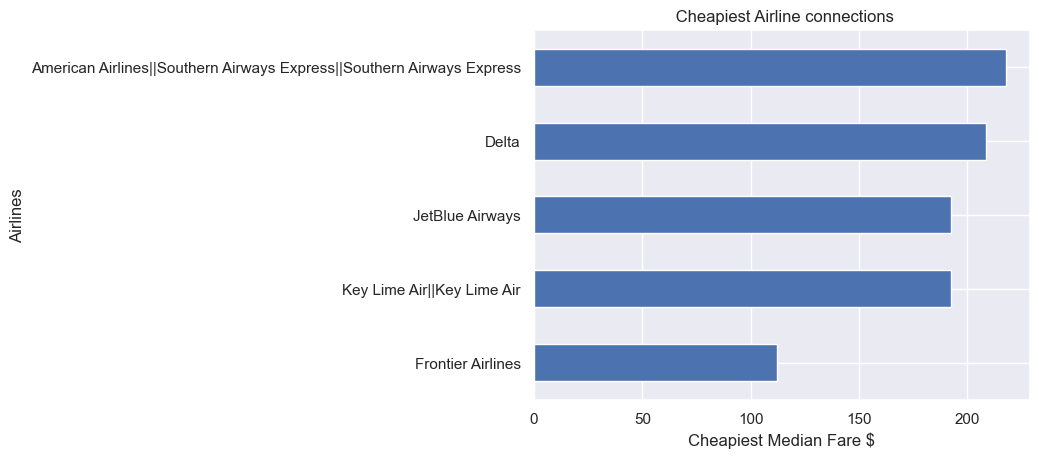

In [127]:
# Step 5: Explode the list of airline names to split into individual rows (without creating unnecessary duplicates)
# Here, the adjustment is done before the split, so we don't explode and aggregate directly
airline_fare_stats = (
    df.groupby('segmentsAirlineName', observed=True)['totalFare']
    .agg(['mean', 'median','min', 'max', 'count'])
    .sort_values(by='median', ascending=True)
)
airline_fare_stats['median'].head().plot(kind='barh')
plt.ylabel('Airlines')
plt.xlabel('Cheapiest Median Fare $')
plt.title(' Cheapiest Airline connections')



i decided to keep those as they are because you cannot split the fare among all of segment airlinenames because , you don't know what each airline company shall get from each fare we have? if you know then tell us, but if you don't know then use the whole segment in your analysis

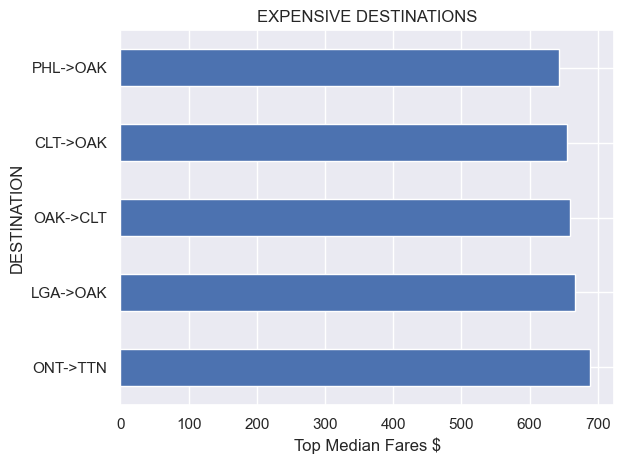

In [123]:
airline_fare_stats = (
    df.groupby('start_END_Destination', observed=True)['totalFare']
    .agg(['mean', 'median','min', 'max', 'count'])
    .sort_values(by='median', ascending=False)
)
airline_fare_stats['median'].head().plot(kind='barh')
plt.ylabel('DESTINATION')
plt.xlabel('Top Median Fares $')
plt.title("EXPENSIVE DESTINATIONS")
plt.tight_layout()


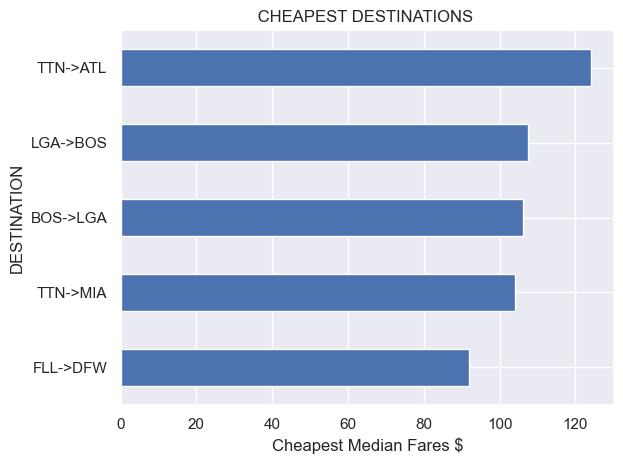

In [124]:
airline_fare_stats = (
    df.groupby('start_END_Destination', observed=True)['totalFare']
    .agg(['mean', 'median','min', 'max', 'count'])
    .sort_values(by='median', ascending=True)
)
airline_fare_stats['median'].head().plot(kind='barh')
plt.ylabel('DESTINATION')
plt.xlabel('Cheapest Median Fares $')
plt.title(" CHEAPEST DESTINATIONS  ")
plt.tight_layout()


- we could dig deep to see how far is the TTN to ATL, why this cheap ? 
- same for others , are they 3 departures or 2 or non ? these kinds of questions 

## PUTTING AN EXTRA FILTER SUCH AS NOT REFUNDABLE

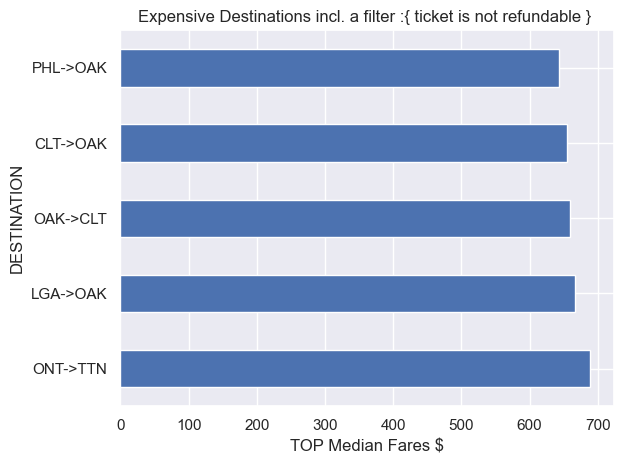

In [125]:
airline_fare_stats = (
    df[~df['isRefundable']]
    .groupby('start_END_Destination', observed=True)['totalFare']
    .agg(['mean', 'median','min', 'max', 'count'])
    .sort_values(by='median', ascending=False)
)
airline_fare_stats['median'].head().plot(kind='barh')
plt.title('Expensive Destinations incl. a filter :{ ticket is not refundable } ')
plt.ylabel('DESTINATION')
plt.xlabel('TOP Median Fares $')
plt.tight_layout()
